# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import copy
from sklearn.metrics import classification_report,confusion_matrix
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tf
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.random.seed(42)
torch.manual_seed(42)

# Configuration

In [3]:
img_dir="/kaggle/input/emds7-1/EMDS7_Preprocessed/EMDS7_Preprocessed"
map_file="/kaggle/input/emds7-1/class_mapping.csv"

classes=["Not-Contaminated","Contaminated"]

batch_size=4
device="cuda"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [4]:
data=pd.read_csv(map_file)
harmful_microorganism=data[data["Harmful"]==1]["Folder Name"].values

# Data Augmentation

In [5]:
train_transform=A.Compose([A.OneOf([A.HorizontalFlip(),
                                    A.VerticalFlip()],p=1),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),
                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.Resize(height=600,width=800),
                           A.Normalize()])
                          
val_transform=A.Compose([A.Resize(height=600,width=800),
                         A.Normalize()])

# Custom Dataset

In [6]:
img_files=[]
for dirname in os.listdir(img_dir):
    for img_path in os.listdir(os.path.join(img_dir,dirname)):
        img_files.append(img_path)

In [7]:
class Microorganism(Dataset):
    def __init__(self,img_dir,filename_list,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.filename_list=sorted(filename_list)
        self.transform=transform
        
    def __len__(self):
        return len(self.filename_list)
    
    def __getitem__(self,idx):
        img_name=self.filename_list[idx]
        img_folder=img_name.split("-")[0]+"-"+img_name.split("-")[1]
        img_pth=os.path.join(self.img_dir,img_folder,img_name)
        img=cv2.imread(img_pth)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        label=0
        if img_folder in harmful_microorganism:
            label=1
        
        if self.transform is not None:
            transformed=self.transform(image=img)
            img=transformed["image"]
            
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        label=torch.tensor(label)
        
        return img,label

In [8]:
train_ds=Microorganism(img_dir,img_files,train_transform)
val_ds=Microorganism(img_dir, img_files,val_transform)

# Dataset Splitting

In [9]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

# DataLoader

In [10]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  pin_memory=True if device=="cuda" else False)

# Model

In [11]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]
    
def training(model,epochs,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,weights_path):
    best_val_acc=0.0
    best_weights=copy.deepcopy(model.state_dict())
    loss_dict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    
    for epoch in range(epochs):
        
        train_loss=0.0
        train_acc=0.0
        train_len=len(train_dl.dataset)
        val_loss=0.0
        val_acc=0.0
        val_len=len(val_dl.dataset)
        current_lr=get_lr(optimizer)
        
        model.train()
        for imgs,labels in train_dl:
            imgs,labels=imgs.to(device),labels.to(device)
            output=model(imgs)
            loss=loss_fn(output,labels)
            
            train_loss+=loss.item()
            pred_labels=output.argmax(dim=1)
            train_acc+=(labels==pred_labels).sum().item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        with torch.no_grad():
            for imgs,labels in val_dl:
                imgs,labels=imgs.to(device),labels.to(device)
                output=model(imgs)
                loss=loss_fn(output,labels)
                
                val_loss+=loss.item()
                pred_labels=output.argmax(dim=1)
                val_acc+=(labels==pred_labels).sum().item()
            
        lr_scheduler.step(val_loss)
        if current_lr!=get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)
            
        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")
            
        loss_dict["train_loss"].append(train_loss/train_len)  
        loss_dict["train_acc"].append(train_acc/train_len)
        loss_dict["val_loss"].append(val_loss/val_len)  
        loss_dict["val_acc"].append(val_acc/val_len)
        
        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}") 
        print("*"*50,"\n")
        
    torch.save(best_weights,weights_path)
    return loss_dict

In [12]:
def get_model(weights=None):
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=2)
    model.to(device)
    
    return model

# Feature Extractor

In [13]:
weights=EfficientNet_B0_Weights.DEFAULT
model=get_model(weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 254MB/s]


In [14]:
for name,params in model.named_children():
    if name!="classifier":
        params.requires_grad=False
    
optimizer=optim.Adam(model.classifier.parameters(),lr=1e-3)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
extractor_weights_path="/kaggle/working/extractor_model.pth"

In [15]:
loss_dict=training(model,15,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   extractor_weights_path)

Updating Best Model weights
1/15: Training
loss: 0.6046389096792775 accuracy: 0.6767136606708799
1/15: Evaluating
loss: 0.49463098095013547 accuracy: 0.7939560439560439
************************************************** 

Updating Best Model weights
2/15: Training
loss: 0.5686649859502122 accuracy: 0.7029654837141468
2/15: Evaluating
loss: 0.46552405088812443 accuracy: 0.8131868131868132
************************************************** 

3/15: Training
loss: 0.5427729567684012 accuracy: 0.7282450170150705
3/15: Evaluating
loss: 0.4877337029019555 accuracy: 0.7664835164835165
************************************************** 

4/15: Training
loss: 0.5364089550239459 accuracy: 0.7297034516285853
4/15: Evaluating
loss: 0.44671225187542674 accuracy: 0.7857142857142857
************************************************** 

5/15: Training
loss: 0.5272440993936536 accuracy: 0.7413709285367039
5/15: Evaluating
loss: 0.45043737858861355 accuracy: 0.7912087912087912
****************************

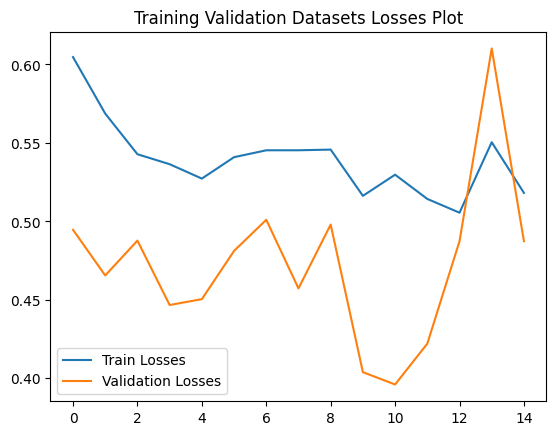

In [16]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

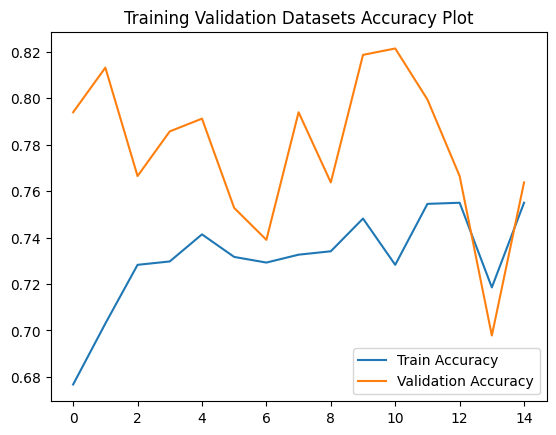

In [17]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

# Fine Tuning

In [18]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/extractor_model.pth"))

<All keys matched successfully>

In [19]:
optimizer=optim.Adam(model.parameters(),lr=3e-5,weight_decay=1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/kaggle/working/finetuning_model.pth"

In [20]:
loss_dict=training(model,25,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/25: Training
loss: 0.47864951948894713 accuracy: 0.7802625182304327
1/25: Evaluating
loss: 0.4170935534677663 accuracy: 0.8104395604395604
************************************************** 

Updating Best Model weights
2/25: Training
loss: 0.3755034727484031 accuracy: 0.8361691784151677
2/25: Evaluating
loss: 0.30109787818330985 accuracy: 0.8818681318681318
************************************************** 

3/25: Training
loss: 0.3118478478750646 accuracy: 0.8760330578512396
3/25: Evaluating
loss: 0.31016805675904174 accuracy: 0.8434065934065934
************************************************** 

4/25: Training
loss: 0.2634031573563133 accuracy: 0.8886728245017015
4/25: Evaluating
loss: 0.40053271494580656 accuracy: 0.8131868131868132
************************************************** 

5/25: Training
loss: 0.2475410111947551 accuracy: 0.9003403014098201
5/25: Evaluating
loss: 0.28649362532299133 accuracy: 0.8708791208791209
***************************

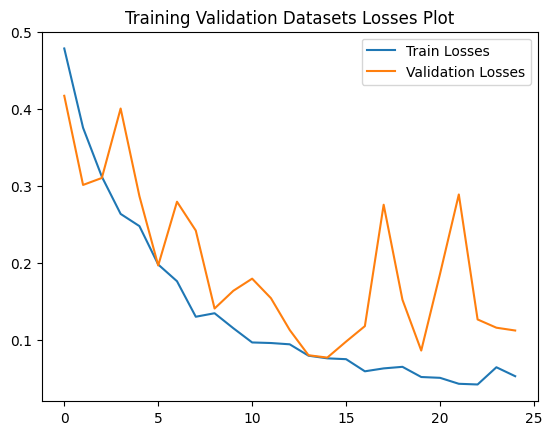

In [21]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

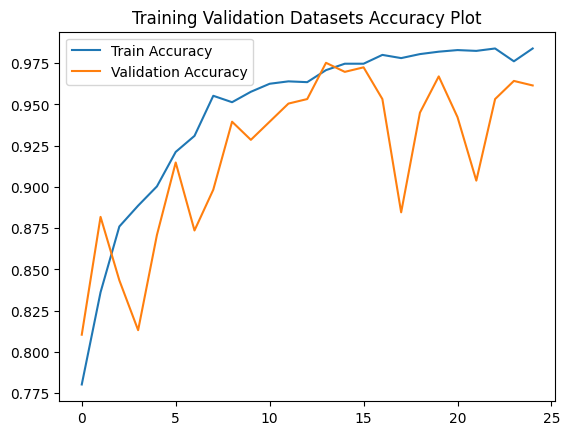

In [22]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

# Evalution

In [23]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/finetuning_model.pth"))

<All keys matched successfully>

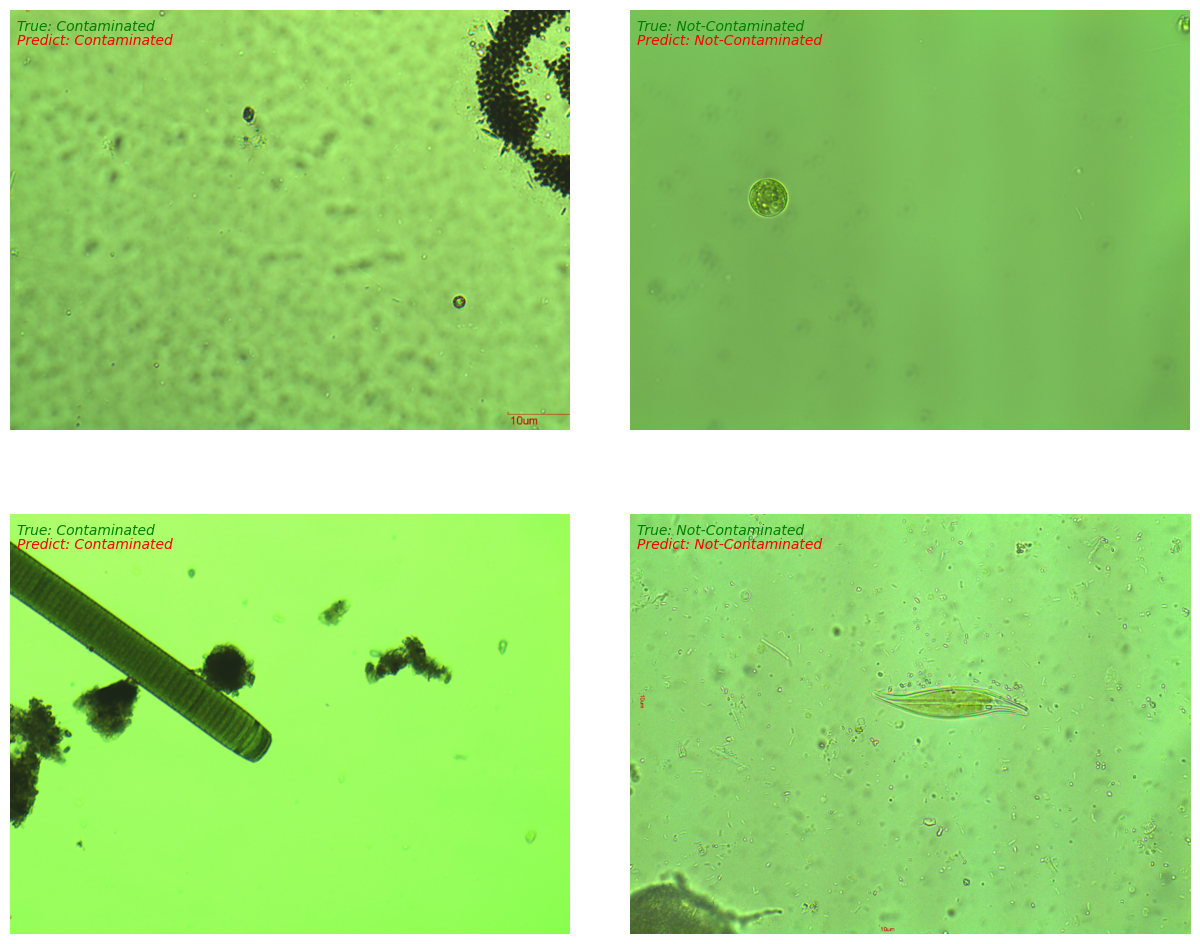

In [24]:
fig,axes=plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(val_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,30,"True: "+ classes[labels[i].item()],style ='italic',
               fontsize = 10, color ="green")
    ax[i].text(10,50,"Predict: "+ classes[pred_label.item()],style ='italic',
                fontsize = 10, color ="red")
    ax[i].axis("off")

In [25]:
y_true=[]
y_pred=[]
model.eval()
with torch.no_grad():
    for j,(imgs,labels) in enumerate(val_dl):
        imgs,labels=imgs.to(device),labels.to(device)
        output=model(imgs)
        pred_labels=output.argmax(dim=1)
        y_true+=labels.tolist()
        y_pred+=pred_labels.tolist()

In [26]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       211
           1       0.97      0.97      0.97       153

    accuracy                           0.98       364
   macro avg       0.97      0.98      0.97       364
weighted avg       0.98      0.98      0.98       364

